In [56]:
experiment='run_330d_iabp5'

In [57]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from matplotlib.tri import Triangulation
from matplotlib import cm, patches, collections

from pynextsim import NextsimBin
from pynextsim.nextsim_mesh import NextsimMesh

from pynextsim.gmshlib import GmshMesh

from pynextsim.drifter_time_series import *
import pynextsim.lib as nsl

import pandas as pd
import os

%matplotlib notebook

In [58]:
mesh_file='/data/experiments/'+experiment+'/mesh_final.bin'
mesh = NextsimMesh(mesh_file)

In [59]:
mesh.mapping


<Other Coordinate Operation Transformer: stere>
Description: PROJ-based coordinate operation
Area of Use:
- undefined

In [60]:
field_file='/data/experiments/'+experiment+'/field_final.bin'
field = NextsimBin(field_file)

In [61]:
drifters_file='/data/experiments/'+experiment+'/IABP_Drifters_20060202.txt'

In [62]:
df = pd.read_csv(drifters_file, delimiter=r"\s+")

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36767 entries, 0 to 36766
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Year           36767 non-null  int64  
 1   Month          36767 non-null  int64  
 2   Day            36767 non-null  int64  
 3   Hour           36767 non-null  int64  
 4   BuoyID         36767 non-null  int64  
 5   Lat            36767 non-null  float64
 6   Lon            36767 non-null  float64
 7   Concentration  36767 non-null  float64
dtypes: float64(3), int64(5)
memory usage: 2.2 MB


In [64]:
df.head()

Year  Month  Day  Hour  BuoyID     Lat      Lon  Concentration
0  2006      2    2     0    1907  81.979 -127.722        0.99512
1  2006      2    2     0    2415  77.022 -140.799        0.99703
2  2006      2    2     0    2416  73.552 -140.754        0.99617
3  2006      2    2     0    2417  75.104 -141.579        0.99637
4  2006      2    2     0    2419  75.817 -146.290        0.99603

In [65]:
drifters_position = df[["BuoyID","Lat","Lon"]]

In [66]:
list_buoys = df['BuoyID'].tolist()
list_red = list(dict.fromkeys(list_buoys))
print(len(list_buoys),len(list_red))

36767 60


In [67]:
os.mkdir('/data/experiments/'+experiment+'/drifters')
for i in np.arange(len(list_red)):
    print(list_red[i])
    pos_buoy=drifters_position.loc[drifters_position['BuoyID'] == list_red[i]]
    shp = pos_buoy['Lon'].shape
    X = np.nan*np.ones(shape=shp)
    Y = np.nan*np.ones(shape=shp)
    X,Y=mesh.mapping(pos_buoy['Lon'],pos_buoy['Lat'])
    np.savez('/data/experiments/'+experiment+'/drifters/drifter_'+str(list_red[i]), X,Y)

1907
2415
2416
2417
2419
3691
3692
3981
5317
7440
7948
7949
7950
22068
22082
22086
24224
25752
25820
25887
53537
53541
23678
1908
26919
26916
26917
5318
9115
1222
19579
8057
53540
8067
4838
66303
66304
66305
5303
5311
5312
5314
3693
66301
66302
66739
66740
11247
64878
64880
64882
64881
64879
64877
11248
11249
25776
26699
66268
7413


In [68]:
print(np.min(X), np.max(X), np.min(Y),np.max(Y))

-1329165.3868372526 -1182720.7483274988 94795.65924626293 227309.00718414562


In [69]:
!ls /data/experiments/$experiment/drifters/

drifter_11247.npz  drifter_24224.npz  drifter_5311.npz	 drifter_66301.npz
drifter_11248.npz  drifter_25752.npz  drifter_5312.npz	 drifter_66302.npz
drifter_11249.npz  drifter_25776.npz  drifter_5314.npz	 drifter_66303.npz
drifter_1222.npz   drifter_25820.npz  drifter_5317.npz	 drifter_66304.npz
drifter_1907.npz   drifter_25887.npz  drifter_5318.npz	 drifter_66305.npz
drifter_1908.npz   drifter_26699.npz  drifter_53537.npz  drifter_66739.npz
drifter_19579.npz  drifter_26916.npz  drifter_53540.npz  drifter_66740.npz
drifter_22068.npz  drifter_26917.npz  drifter_53541.npz  drifter_7413.npz
drifter_22082.npz  drifter_26919.npz  drifter_64877.npz  drifter_7440.npz
drifter_22086.npz  drifter_3691.npz   drifter_64878.npz  drifter_7948.npz
drifter_23678.npz  drifter_3692.npz   drifter_64879.npz  drifter_7949.npz
drifter_2415.npz   drifter_3693.npz   drifter_64880.npz  drifter_7950.npz
drifter_2416.npz   drifter_3981.npz   drifter_64881.npz  drifter_8057.npz
drifter_2417.npz   drifter_4838.npz 

<IPython.core.display.Javascript object>


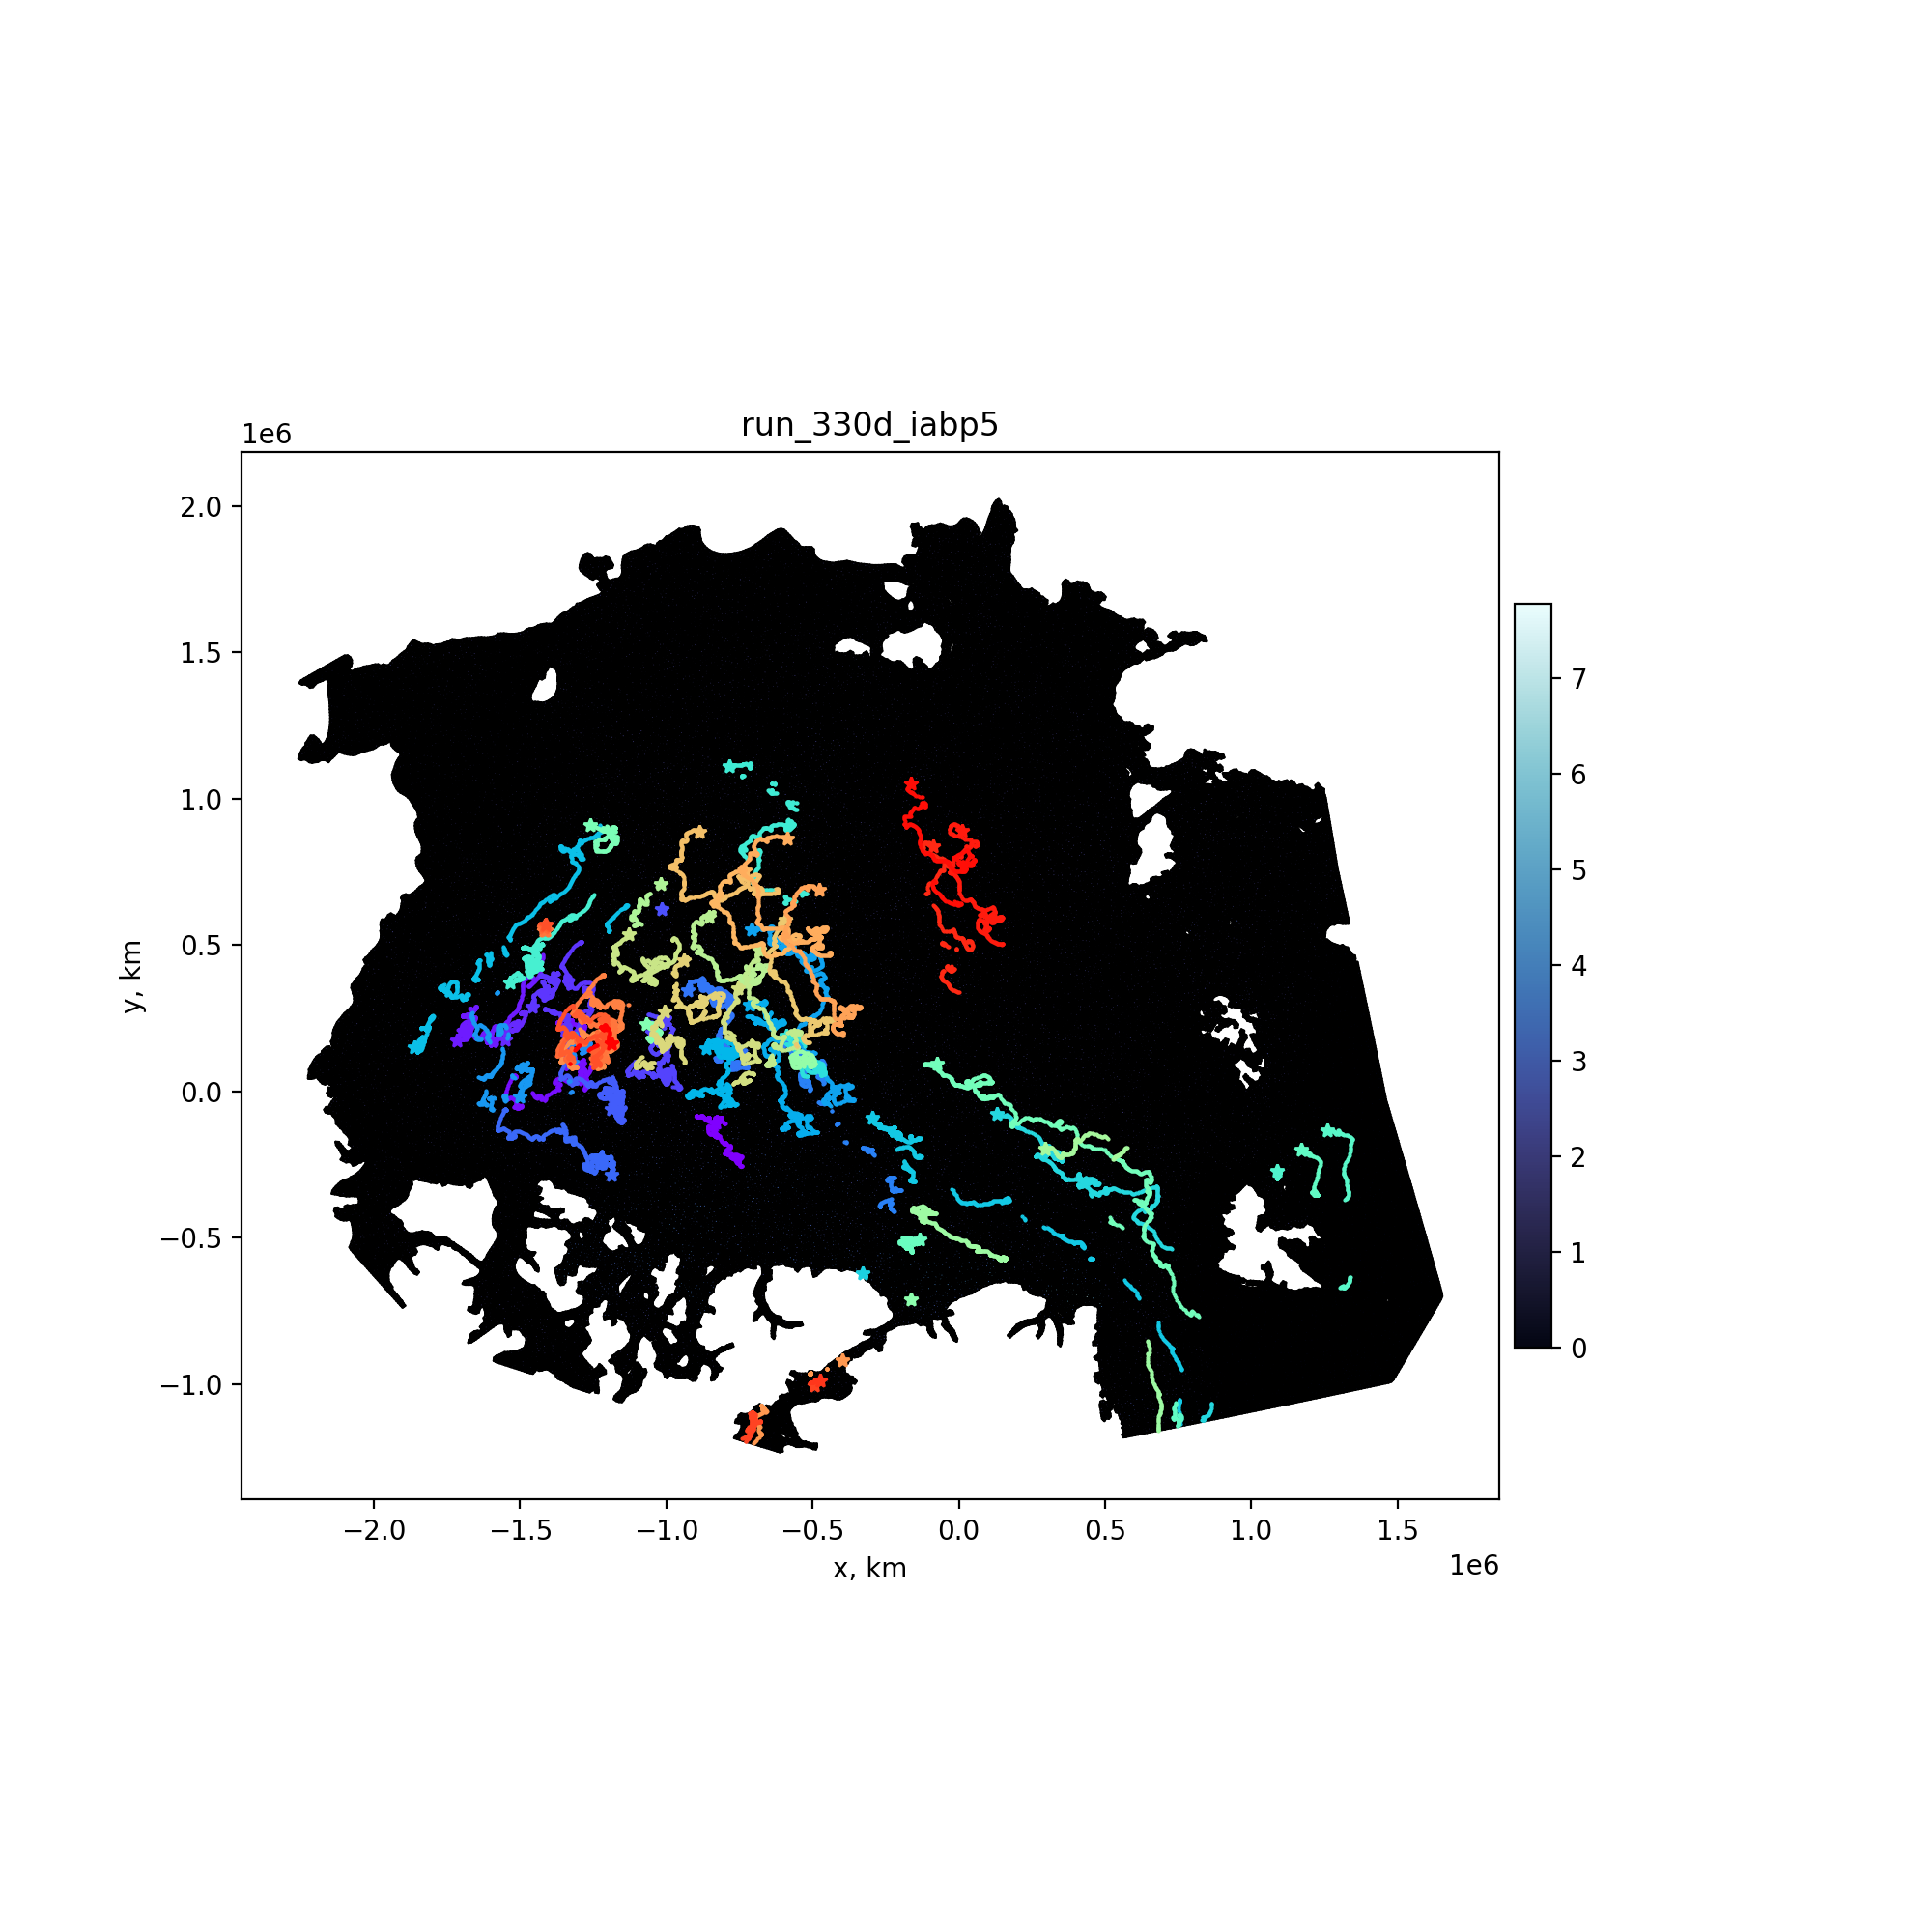

In [70]:
ax = plt.figure(figsize=(10, 10)).add_subplot(111)
fig = ax.figure

sfac=1
cmap='ice'
cmap2 = cm.get_cmap('rainbow', len(list_red))

#mesh parameters
nodes_x, nodes_y = mesh.get_nodes_xy()
indices = mesh.get_indices("triangles", numbering='gmsh', asvector=False)
Nn = mesh.num_nodes
Ne = mesh.num_triangles

patch_list  = []

for inds in indices:
    ccl   = []
    for n in inds:
        ccl.append((sfac*nodes_x[n],sfac*nodes_y[n]))
    ccl.append(ccl[0]) # close the contour
    patch_list.append(patches.Polygon(ccl,True,linewidth=0))

pc = collections.PatchCollection(patch_list, cmap=cmap, alpha=1)

#data to fill
thick = field.get_var('Thickness')
data = thick

pc.set_array(data)
pc.set_edgecolor('k')

ax.add_collection(pc)

for i in np.arange(len(list_red)):
    pos_buoy=drifters_position.loc[drifters_position['BuoyID'] == list_red[i]]
    shp = pos_buoy['Lon'].shape
    X = np.nan*np.ones(shape=shp)
    Y = np.nan*np.ones(shape=shp)
    X,Y=mesh.mapping(pos_buoy['Lon'],pos_buoy['Lat'])
    ax.plot(X[0],Y[0],'*',color=matplotlib.colors.rgb2hex(cmap2(i)[:3]),markersize=5)
    for x, y in zip(X, Y):
        ax.plot(x,y,'.',color=matplotlib.colors.rgb2hex(cmap2(i)[:3]),markersize=1)
        
ax.set_xlabel('x, km')
ax.set_ylabel('y, km')

#-1329165.3868372526 -1183291.2684376023 94884.00886036998 225761.49111683283
#ax.set_ylim([-1.5e6,1e6])
#ax.set_xlim([-2e6,1.5e5])
ax.set_aspect('equal')

cbar  = fig.colorbar(pc, ax=ax, orientation="vertical", pad=0.01, shrink=0.5)
plt.title(experiment)
plt.savefig('/plots/plots/map_drifters_iabp_on_iconc_mesh'+experiment+'.png')

<IPython.core.display.Javascript object>


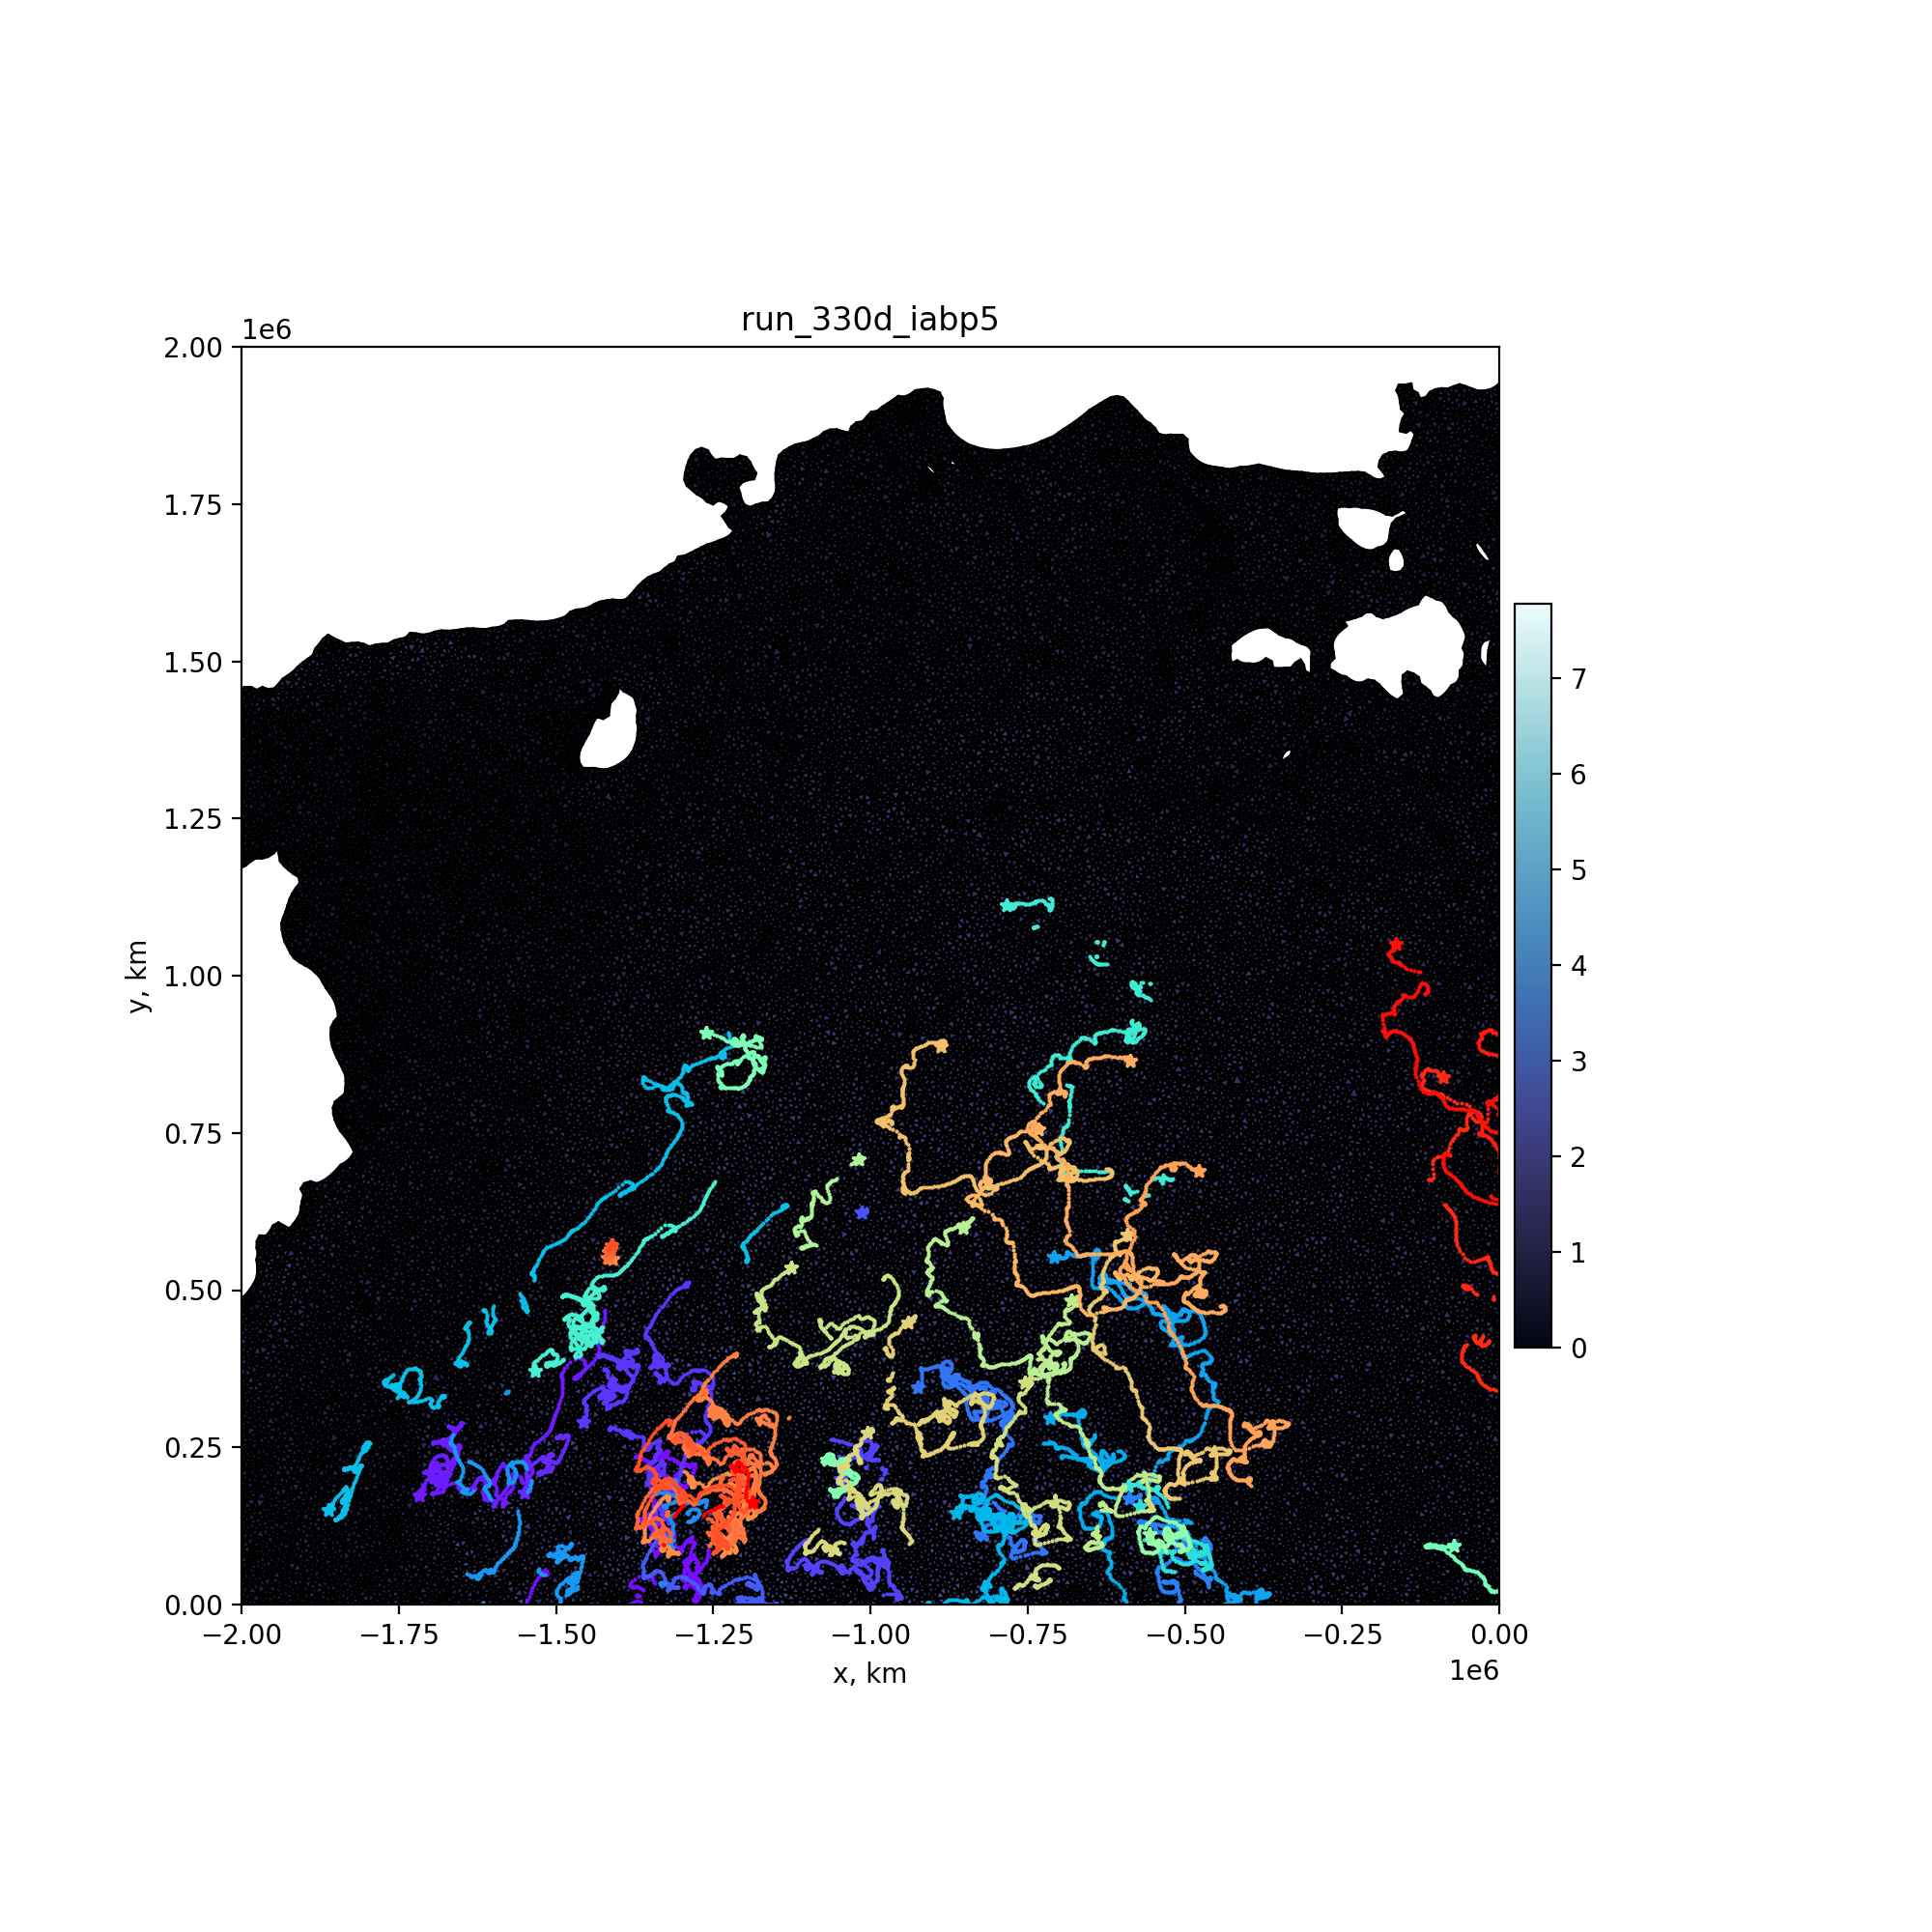

In [71]:
ax = plt.figure(figsize=(10, 10)).add_subplot(111)
fig = ax.figure

sfac=1
cmap='ice'
cmap2 = cm.get_cmap('rainbow', len(list_red))

#mesh parameters
nodes_x, nodes_y = mesh.get_nodes_xy()
indices = mesh.get_indices("triangles", numbering='gmsh', asvector=False)
Nn = mesh.num_nodes
Ne = mesh.num_triangles

patch_list  = []

for inds in indices:
    ccl   = []
    for n in inds:
        ccl.append((sfac*nodes_x[n],sfac*nodes_y[n]))
    ccl.append(ccl[0]) # close the contour
    patch_list.append(patches.Polygon(ccl,True,linewidth=0))

pc = collections.PatchCollection(patch_list, cmap=cmap, alpha=1)

#data to fill
thick = field.get_var('Thickness')
data = thick

pc.set_array(data)
pc.set_edgecolor('k')

ax.add_collection(pc)

for i in np.arange(len(list_red)):
    pos_buoy=drifters_position.loc[drifters_position['BuoyID'] == list_red[i]]
    shp = pos_buoy['Lon'].shape
    X = np.nan*np.ones(shape=shp)
    Y = np.nan*np.ones(shape=shp)
    X,Y=mesh.mapping(pos_buoy['Lon'],pos_buoy['Lat'])
    ax.plot(X[0],Y[0],'*',color=matplotlib.colors.rgb2hex(cmap2(i)[:3]),markersize=5)
    for x, y in zip(X, Y):
        ax.plot(x,y,'.',color=matplotlib.colors.rgb2hex(cmap2(i)[:3]),markersize=1)
        
ax.set_xlabel('x, km')
ax.set_ylabel('y, km')

#-1329165.3868372526 -1183291.2684376023 94884.00886036998 225761.49111683283
ax.set_ylim([0,2e6])
ax.set_xlim([-2e6,0])
ax.set_aspect('equal')

cbar  = fig.colorbar(pc, ax=ax, orientation="vertical", pad=0.01, shrink=0.5)
plt.title(experiment)
plt.savefig('/plots/plots/map_drifters_iabp_on_iconc_mesh'+experiment+'_quart1.png')

<IPython.core.display.Javascript object>


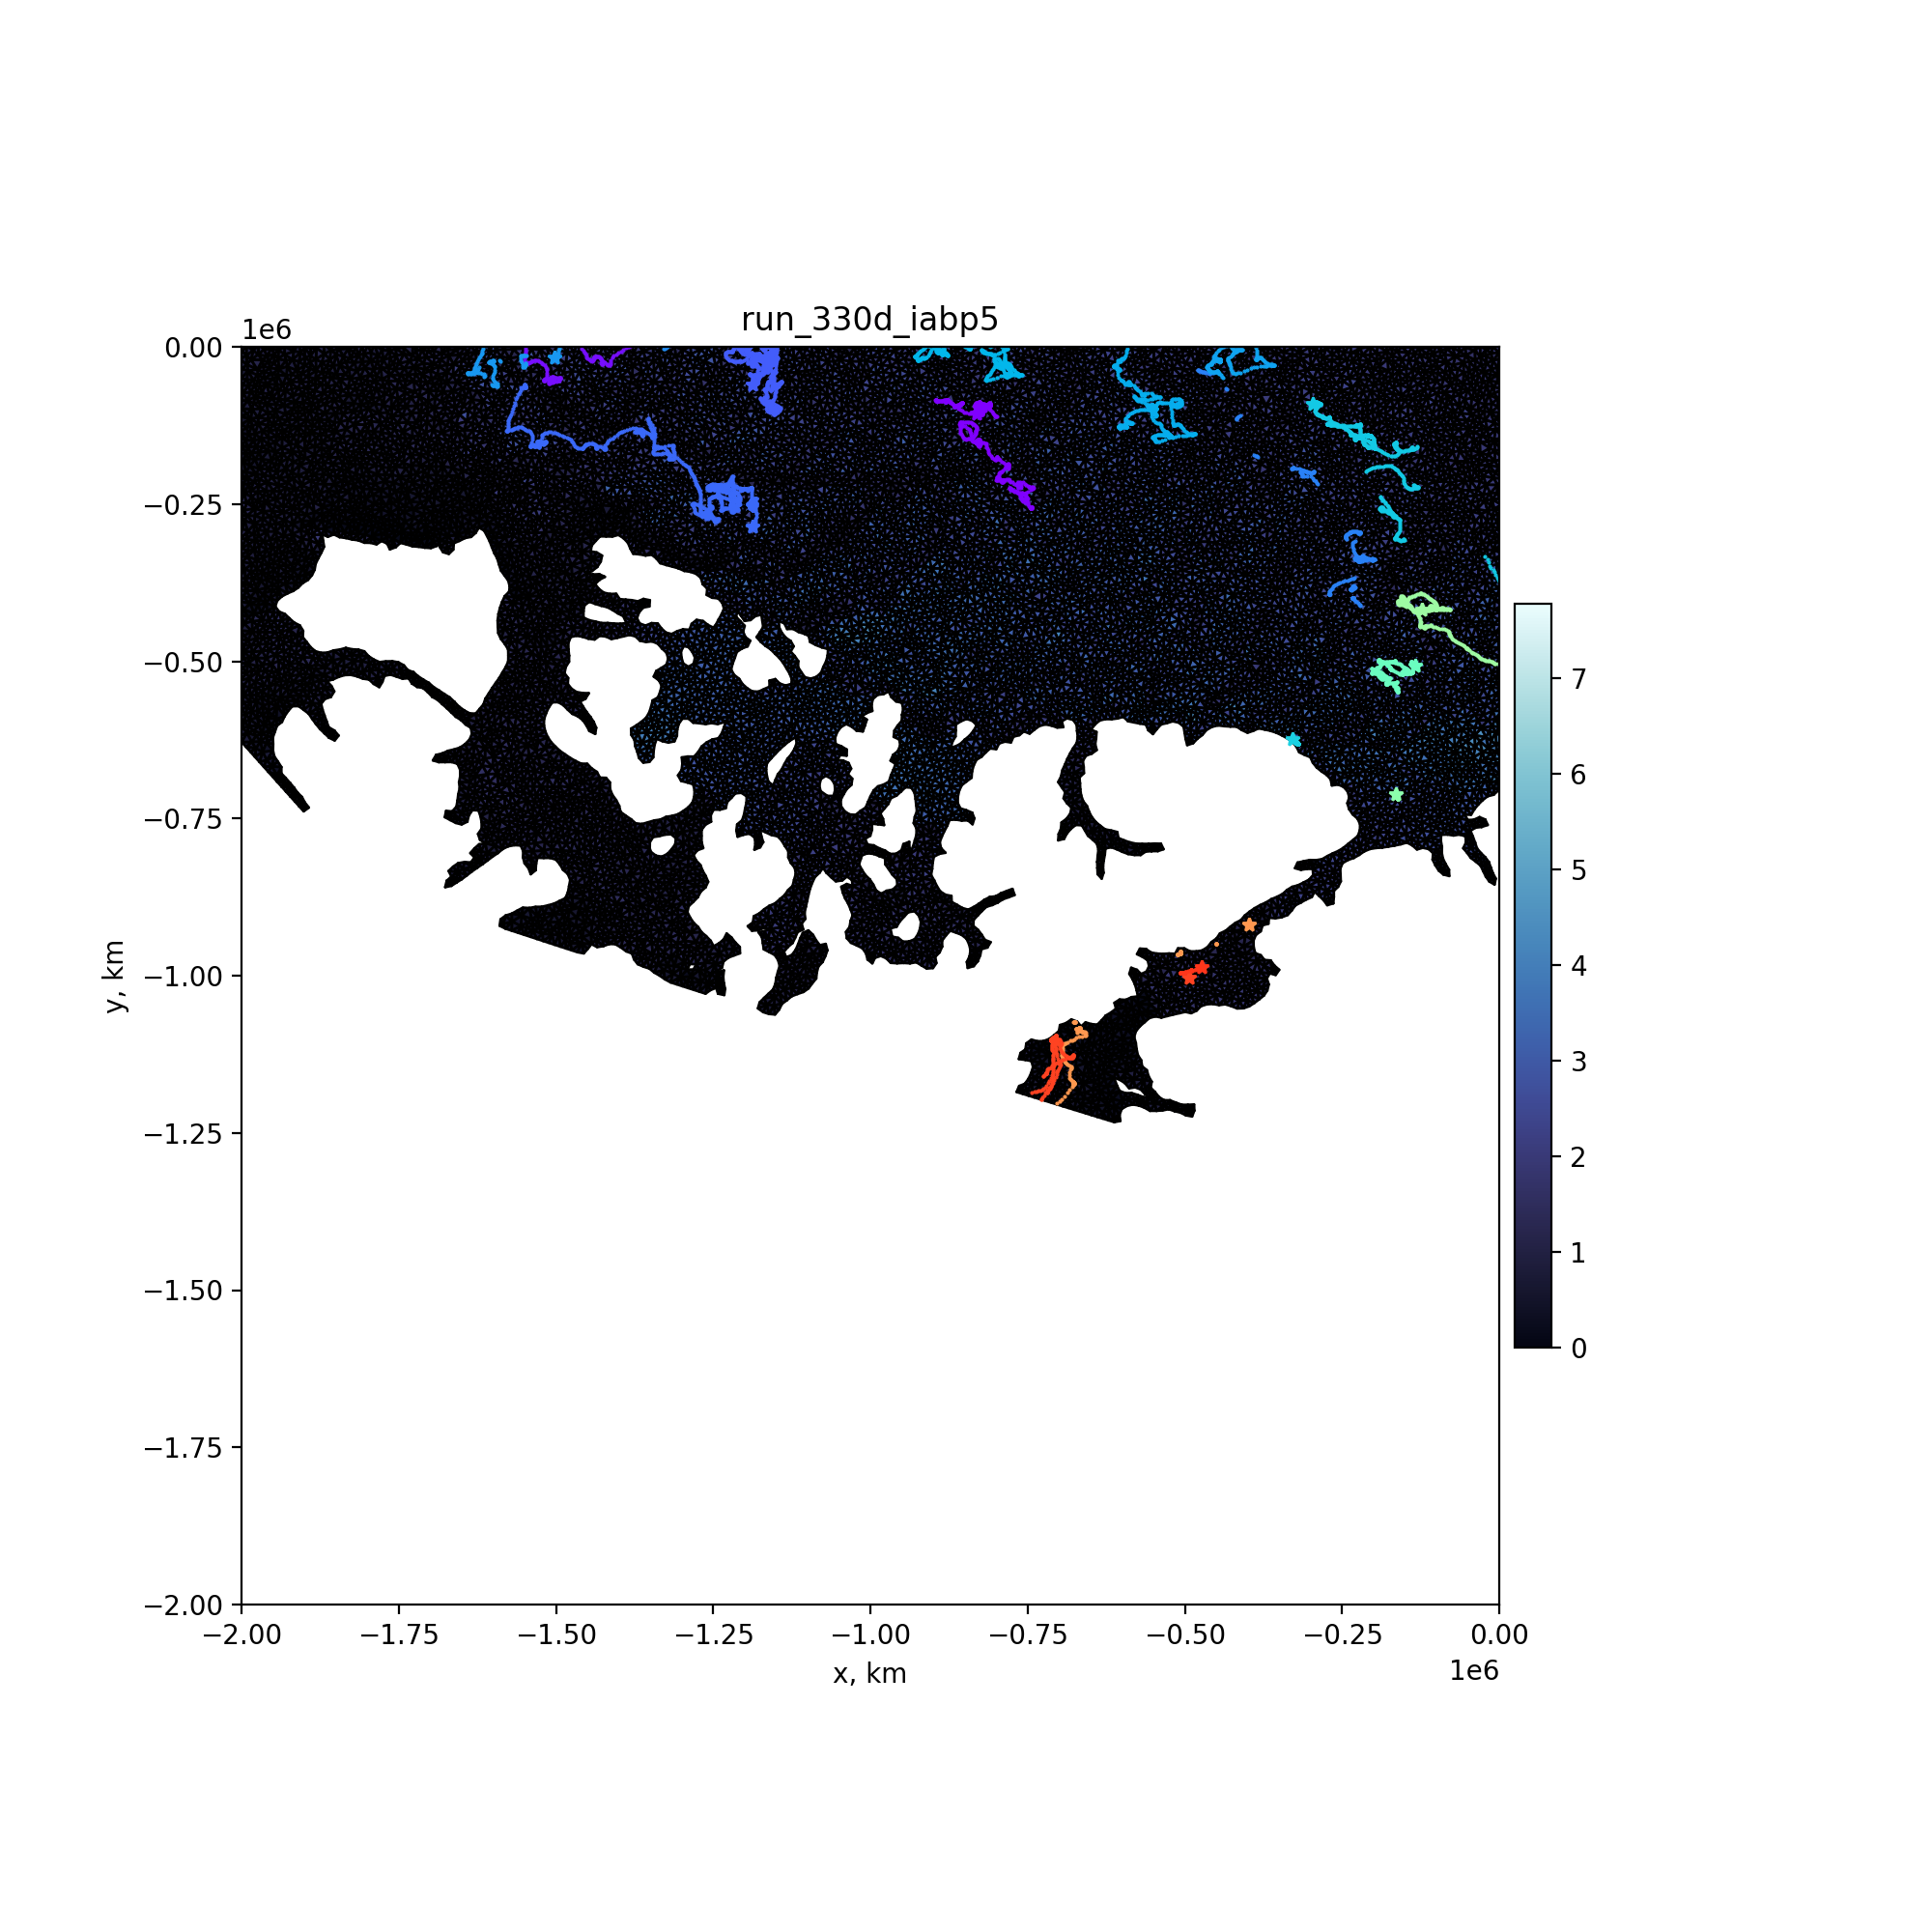

In [72]:
ax = plt.figure(figsize=(10, 10)).add_subplot(111)
fig = ax.figure

sfac=1
cmap='ice'
cmap2 = cm.get_cmap('rainbow', len(list_red))

#mesh parameters
nodes_x, nodes_y = mesh.get_nodes_xy()
indices = mesh.get_indices("triangles", numbering='gmsh', asvector=False)
Nn = mesh.num_nodes
Ne = mesh.num_triangles

patch_list  = []

for inds in indices:
    ccl   = []
    for n in inds:
        ccl.append((sfac*nodes_x[n],sfac*nodes_y[n]))
    ccl.append(ccl[0]) # close the contour
    patch_list.append(patches.Polygon(ccl,True,linewidth=0))

pc = collections.PatchCollection(patch_list, cmap=cmap, alpha=1)

#data to fill
thick = field.get_var('Thickness')
data = thick

pc.set_array(data)
pc.set_edgecolor('k')

ax.add_collection(pc)

for i in np.arange(len(list_red)):
    pos_buoy=drifters_position.loc[drifters_position['BuoyID'] == list_red[i]]
    shp = pos_buoy['Lon'].shape
    X = np.nan*np.ones(shape=shp)
    Y = np.nan*np.ones(shape=shp)
    X,Y=mesh.mapping(pos_buoy['Lon'],pos_buoy['Lat'])
    ax.plot(X[0],Y[0],'*',color=matplotlib.colors.rgb2hex(cmap2(i)[:3]),markersize=5)
    for x, y in zip(X, Y):
        ax.plot(x,y,'.',color=matplotlib.colors.rgb2hex(cmap2(i)[:3]),markersize=1)
        
ax.set_xlabel('x, km')
ax.set_ylabel('y, km')

#-1329165.3868372526 -1183291.2684376023 94884.00886036998 225761.49111683283
ax.set_ylim([-2e6,0])
ax.set_xlim([-2e6,0])
ax.set_aspect('equal')

cbar  = fig.colorbar(pc, ax=ax, orientation="vertical", pad=0.01, shrink=0.5)
plt.title(experiment)
plt.savefig('/plots/plots/map_drifters_iabp_on_iconc_mesh'+experiment+'_quart2.png')

<IPython.core.display.Javascript object>


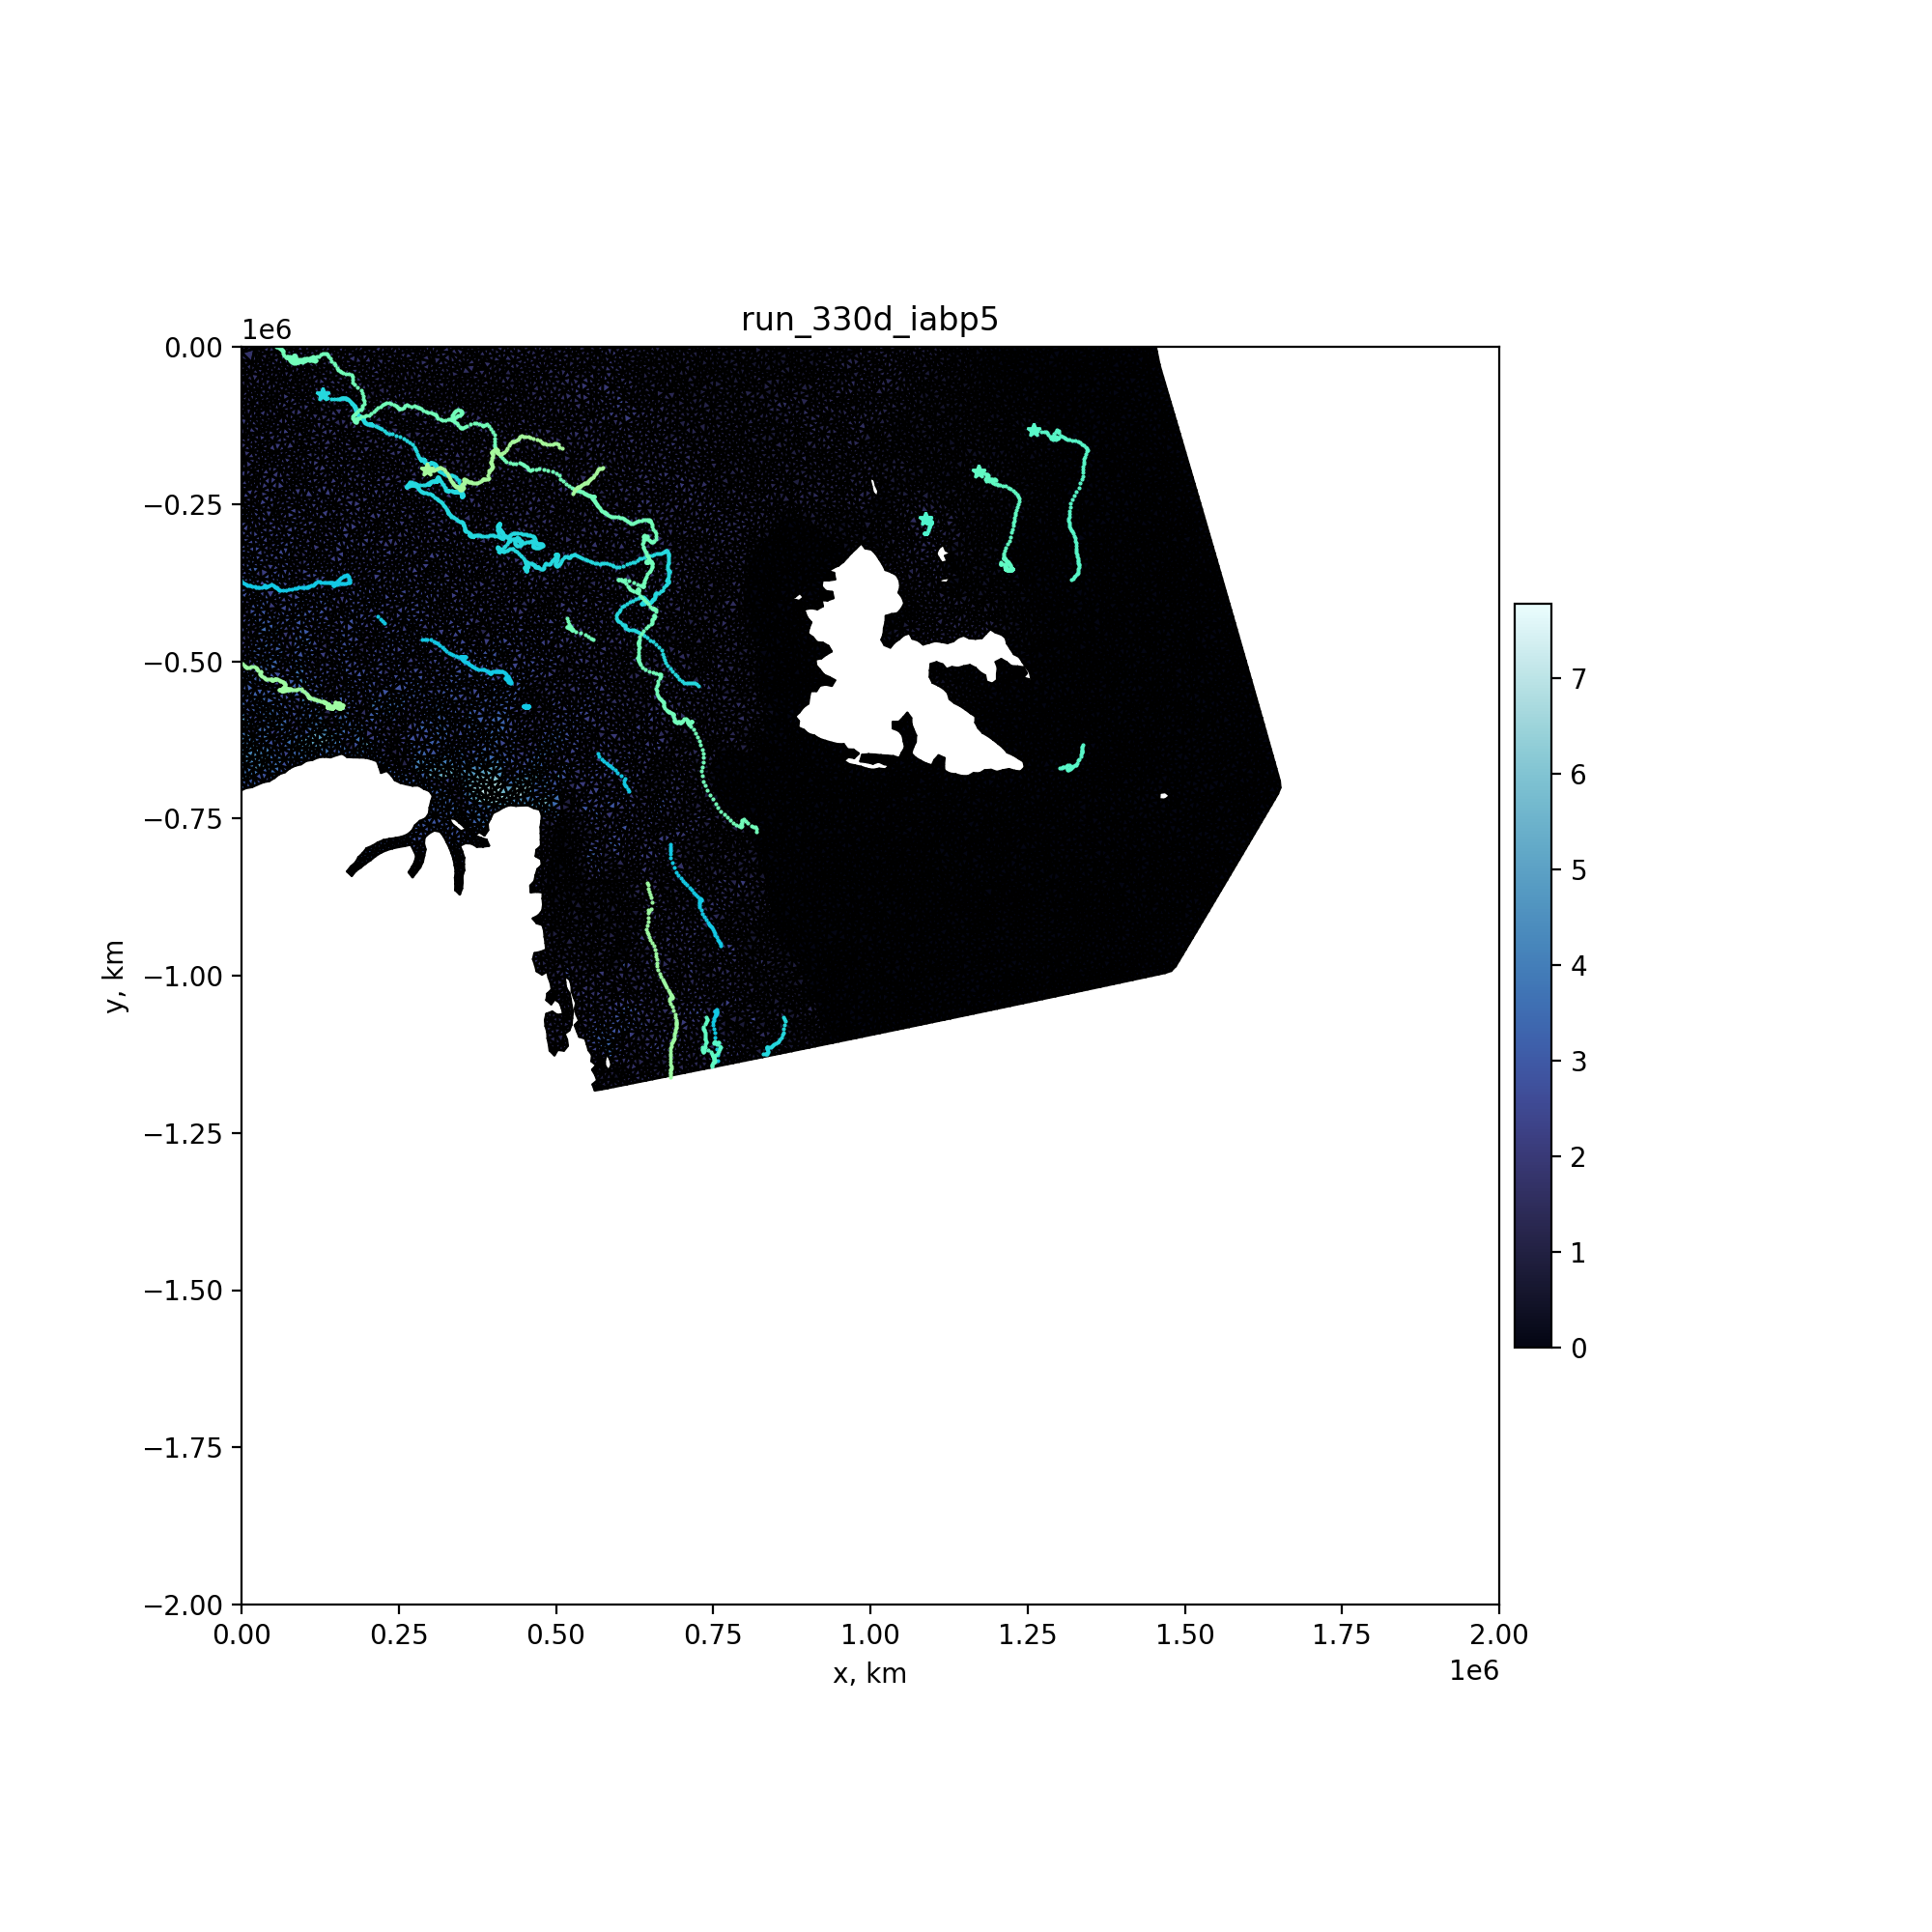

In [73]:
ax = plt.figure(figsize=(10, 10)).add_subplot(111)
fig = ax.figure

sfac=1
cmap='ice'
cmap2 = cm.get_cmap('rainbow', len(list_red))

#mesh parameters
nodes_x, nodes_y = mesh.get_nodes_xy()
indices = mesh.get_indices("triangles", numbering='gmsh', asvector=False)
Nn = mesh.num_nodes
Ne = mesh.num_triangles

patch_list  = []

for inds in indices:
    ccl   = []
    for n in inds:
        ccl.append((sfac*nodes_x[n],sfac*nodes_y[n]))
    ccl.append(ccl[0]) # close the contour
    patch_list.append(patches.Polygon(ccl,True,linewidth=0))

pc = collections.PatchCollection(patch_list, cmap=cmap, alpha=1)

#data to fill
thick = field.get_var('Thickness')
data = thick

pc.set_array(data)
pc.set_edgecolor('k')

ax.add_collection(pc)

for i in np.arange(len(list_red)):
    pos_buoy=drifters_position.loc[drifters_position['BuoyID'] == list_red[i]]
    shp = pos_buoy['Lon'].shape
    X = np.nan*np.ones(shape=shp)
    Y = np.nan*np.ones(shape=shp)
    X,Y=mesh.mapping(pos_buoy['Lon'],pos_buoy['Lat'])
    ax.plot(X[0],Y[0],'*',color=matplotlib.colors.rgb2hex(cmap2(i)[:3]),markersize=5)
    for x, y in zip(X, Y):
        ax.plot(x,y,'.',color=matplotlib.colors.rgb2hex(cmap2(i)[:3]),markersize=1)
        
ax.set_xlabel('x, km')
ax.set_ylabel('y, km')

#-1329165.3868372526 -1183291.2684376023 94884.00886036998 225761.49111683283
ax.set_ylim([-2e6,0])
ax.set_xlim([0,2e6])
ax.set_aspect('equal')

cbar  = fig.colorbar(pc, ax=ax, orientation="vertical", pad=0.01, shrink=0.5)
plt.title(experiment)
plt.savefig('/plots/plots/map_drifters_iabp_on_iconc_mesh'+experiment+'_quart3.png')

<IPython.core.display.Javascript object>


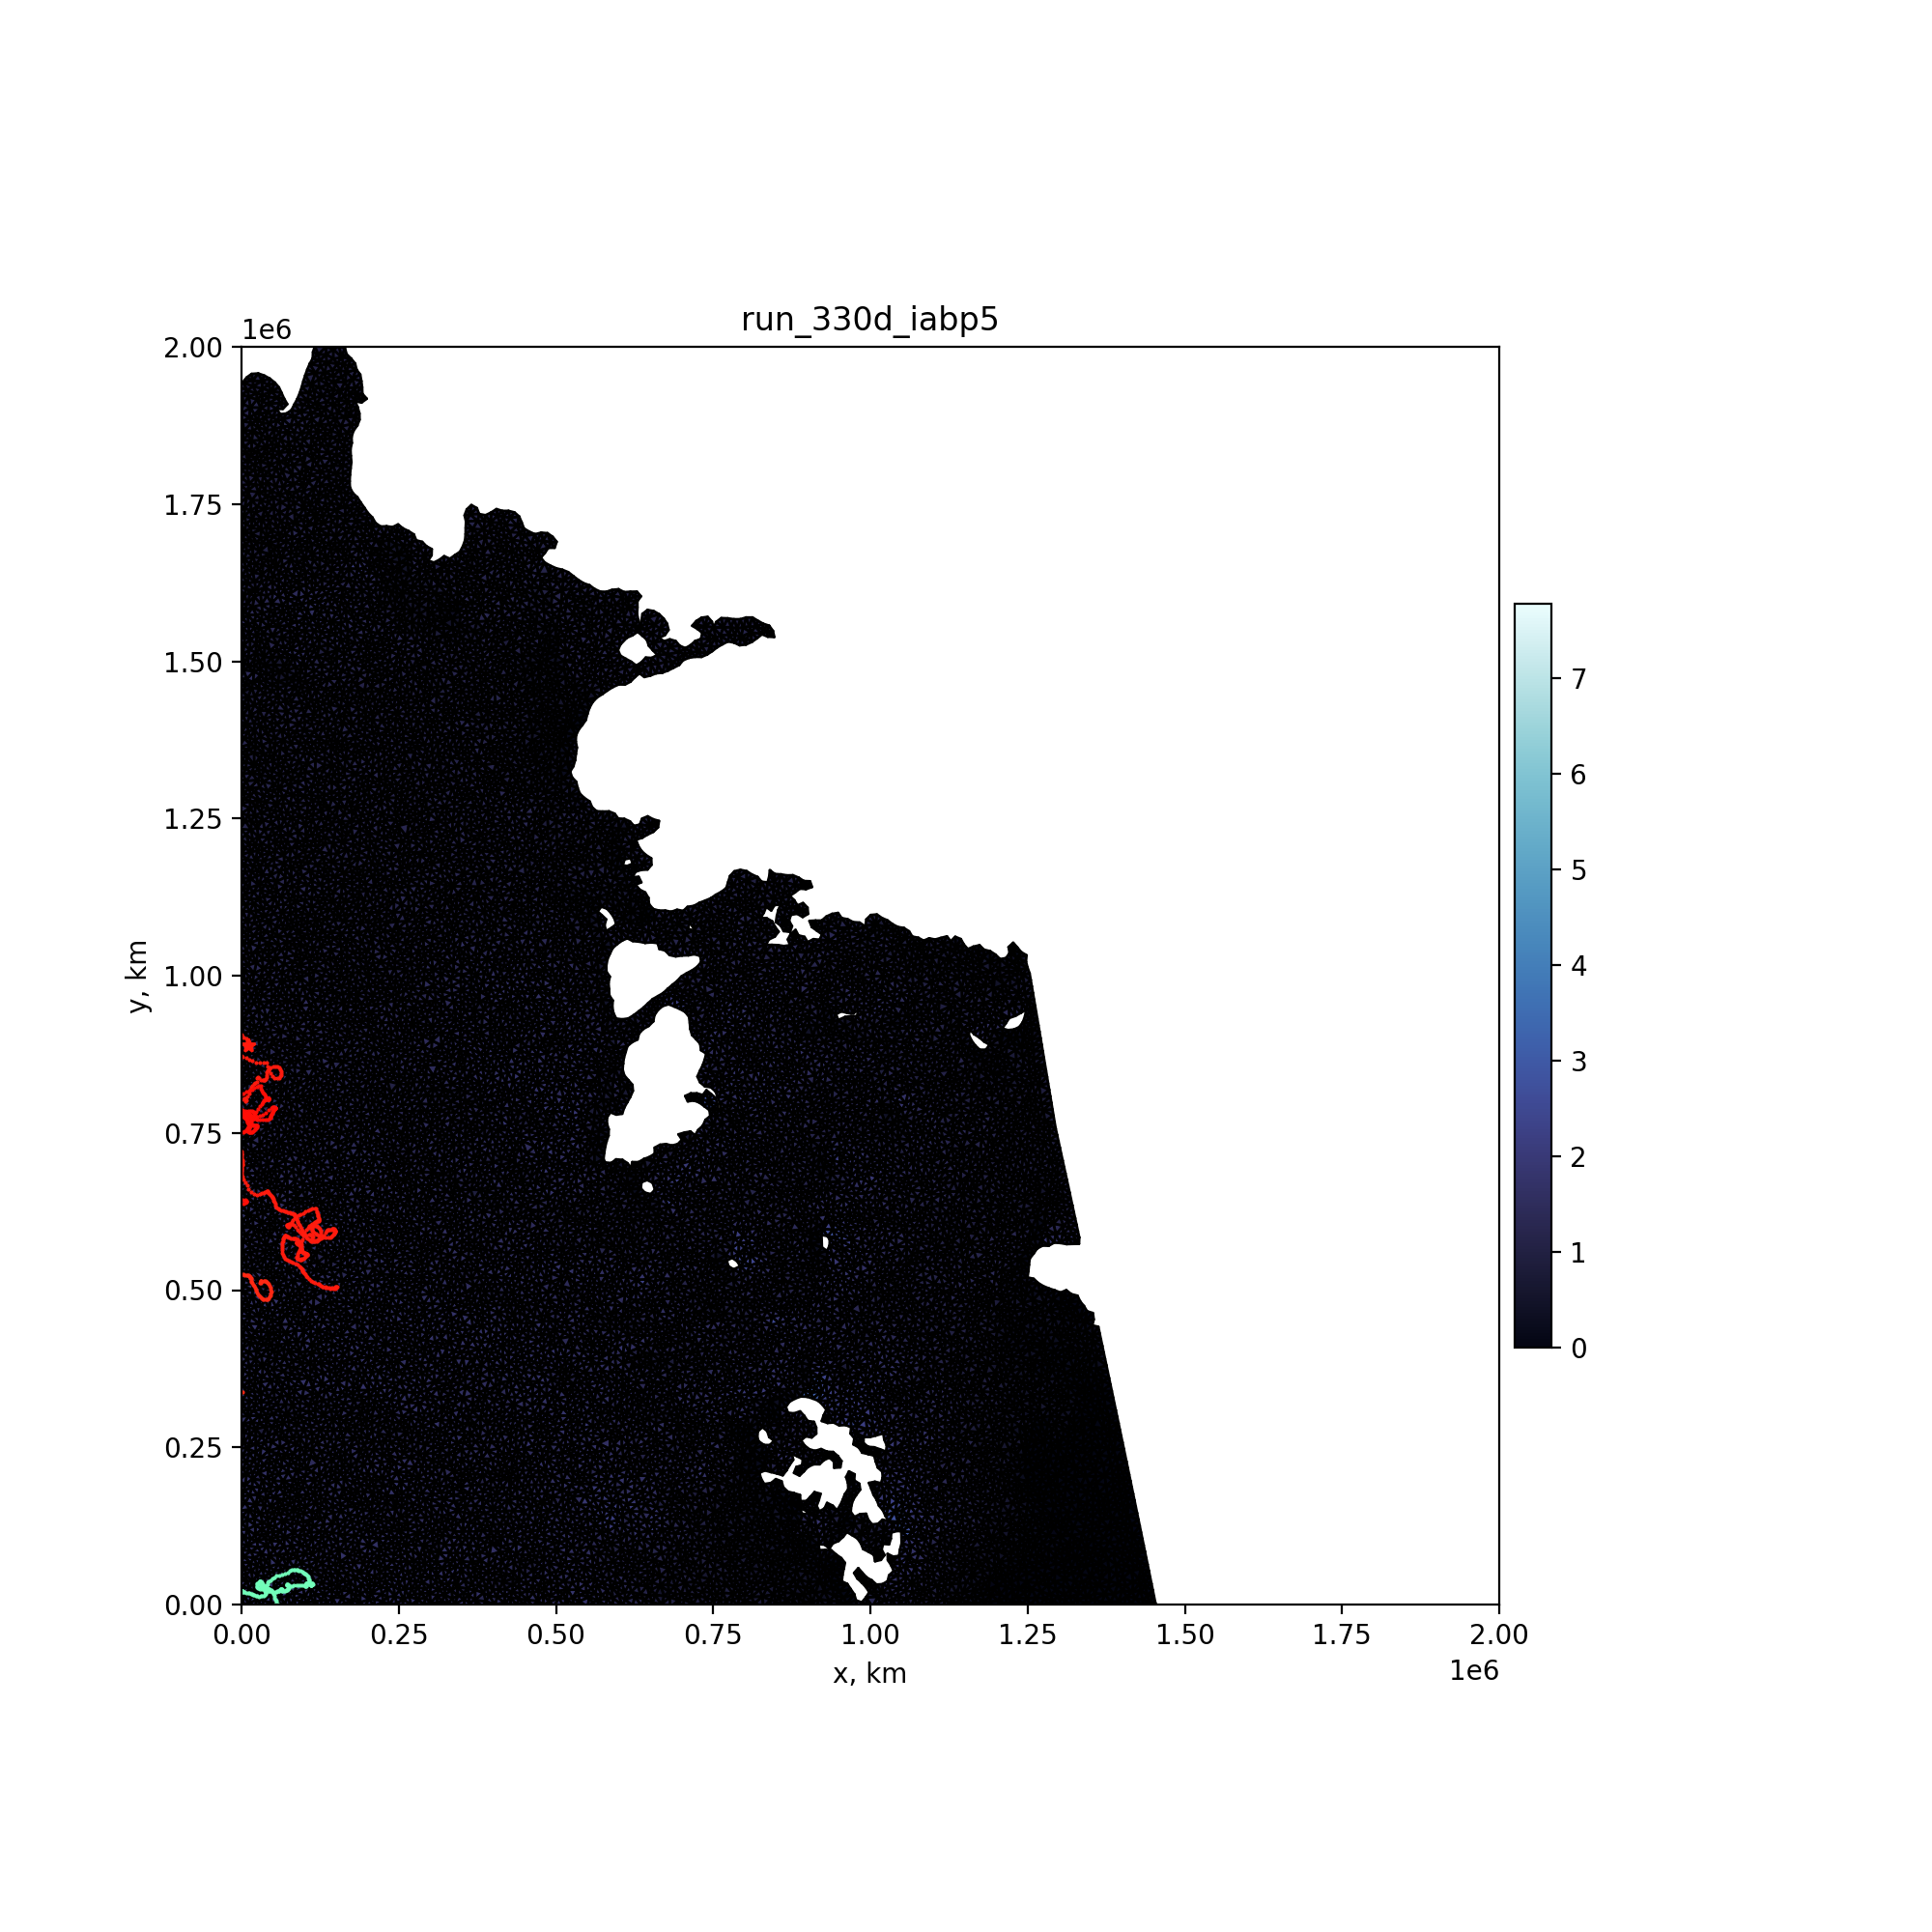

In [74]:
ax = plt.figure(figsize=(10, 10)).add_subplot(111)
fig = ax.figure

sfac=1
cmap='ice'
cmap2 = cm.get_cmap('rainbow', len(list_red))

#mesh parameters
nodes_x, nodes_y = mesh.get_nodes_xy()
indices = mesh.get_indices("triangles", numbering='gmsh', asvector=False)
Nn = mesh.num_nodes
Ne = mesh.num_triangles

patch_list  = []

for inds in indices:
    ccl   = []
    for n in inds:
        ccl.append((sfac*nodes_x[n],sfac*nodes_y[n]))
    ccl.append(ccl[0]) # close the contour
    patch_list.append(patches.Polygon(ccl,True,linewidth=0))

pc = collections.PatchCollection(patch_list, cmap=cmap, alpha=1)

#data to fill
thick = field.get_var('Thickness')
data = thick

pc.set_array(data)
pc.set_edgecolor('k')

ax.add_collection(pc)

for i in np.arange(len(list_red)):
    pos_buoy=drifters_position.loc[drifters_position['BuoyID'] == list_red[i]]
    shp = pos_buoy['Lon'].shape
    X = np.nan*np.ones(shape=shp)
    Y = np.nan*np.ones(shape=shp)
    X,Y=mesh.mapping(pos_buoy['Lon'],pos_buoy['Lat'])
    ax.plot(X[0],Y[0],'*',color=matplotlib.colors.rgb2hex(cmap2(i)[:3]),markersize=5)
    for x, y in zip(X, Y):
        ax.plot(x,y,'.',color=matplotlib.colors.rgb2hex(cmap2(i)[:3]),markersize=1)
        
ax.set_xlabel('x, km')
ax.set_ylabel('y, km')

#-1329165.3868372526 -1183291.2684376023 94884.00886036998 225761.49111683283
ax.set_ylim([0,2e6])
ax.set_xlim([0,2e6])
ax.set_aspect('equal')

cbar  = fig.colorbar(pc, ax=ax, orientation="vertical", pad=0.01, shrink=0.5)
plt.title(experiment)
plt.savefig('/plots/plots/map_drifters_iabp_on_iconc_mesh'+experiment+'_quart4.png')